In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [55]:
weather_data = pd.read_csv('weatherAUS.csv')

In [56]:
weather_data.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,06/12/2008,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,07/12/2008,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,08/12/2008,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,09/12/2008,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,10/12/2008,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


# Analisis de tipos de datos y presencia de datos faltantes.
Se observa que solo las columnas «Date» y «Location» poseen el 100% de los datos. Estas serviran como base para la estimacion e imputacion de los valores faltantes para las otras columnas.

In [43]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# Definicion de Variables

In [46]:
numerical_var = ['MinTemp',
                 'MaxTemp', 
                 'Rainfall', 
                 'Evaporation',
                 'Sunshine',
                 'WindGustSpeed',
                 'WindSpeed9am',
                 'WindSpeed3pm',
                 'Humidity9am',
                 'Humidity3pm',
                 'Pressure9am',	
                 'Pressure3pm',
                 'Cloud9am',
                 'Cloud3pm',
                 'Temp9am',
                 'Temp3pm']

category_var = ['Location',
                'WindGustDir',
                'WindDir9am',
                'WindDir3pm',
                'RainToday']

target_var = ['RainTomorrow']

In [45]:
# Se convierte la columna «Date» a datetime y se la establece como el índice del DataFrame
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%d/%m/%Y')
weather_data.set_index('Date', inplace=True)
weather_data.reset_index(inplace=True)

# Se crean columnas para el año, mes, día y día de la semana basados en la columna «Date»
weather_data['Year'] = weather_data['Date'].dt.year
weather_data['Month'] = weather_data['Date'].dt.month
weather_data['Day'] = weather_data['Date'].dt.day
weather_data['DayOfWeek'] = weather_data['Date'].dt.dayofweek

numerical_var.extend(['Year', 'Month', 'Day', 'DayOfWeek'])

# Estimacion de Valores faltantes

Se inicia el proceso de estimacion e imputacion de valores faltantes con las columnas «MinTemp», «MaxTemp» y «Rainfall». Se utiliza la función interpolate con el método «time» segregando los datos por ubicacoin («Location») para estimar los valores faltantes basados en el tiempo.

In [47]:
weather_data.set_index('Date', inplace=True)
weather_data['MaxTemp'] = weather_data.groupby('Location')['MaxTemp'].transform(lambda group: group.interpolate(method='time'))
weather_data['MinTemp'] = weather_data.groupby('Location')['MinTemp'].transform(lambda group: group.interpolate(method='time'))
weather_data['Rainfall'] = weather_data.groupby('Location')['Rainfall'].transform(lambda group: group.interpolate(method='time'))

# weather_data['WindGustDir'] = weather_data.groupby('Location')['WindGustDir'].transform(lambda group: group.interpolate(method='time'))
# weather_data['WindGustSpeed'] = weather_data.groupby('Location')['WindGustSpeed'].transform(lambda group: group.interpolate(method='time'))
# weather_data['Sunshine'] = weather_data.groupby('Location')['Sunshine'].transform(lambda group: group.interpolate(method='time'))
weather_data.reset_index(inplace=True)

Se observa que la interpolación de tiempo puede no ser capaz de imputar todos los valores faltantes en los datos. 

In [48]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145393 non-null  float64       
 3   MaxTemp        145394 non-null  float64       
 4   Rainfall       145393 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

El método «bfill()» propaga el siguiente valor válido hacia atrás para llenar los valores faltantes. El método «ffill()» propaga el último valor válido hacia adelante para llenar los valores faltantes.

In [49]:
def fill_missing_values(df, columns):
    for column in columns:
        if df[column].isnull().sum() > 0:
            df[column] = df.groupby('Location')[column].transform(lambda group: group.bfill())
        if df[column].isnull().sum() > 0:
            df[column] = df.groupby('Location')[column].transform(lambda group: group.ffill())
    return df

In [50]:
columns = ['MaxTemp', 'MinTemp', 'Rainfall']
weather_data = fill_missing_values(weather_data, columns)

In [51]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

Ciudades («Locations») con todos los valores nulos para la columna Sunhine

In [62]:
locations = weather_data['Location'].unique()

locations_with_all_nulls = []
for loc in locations:
    if weather_data[weather_data['Location'] == loc]['Sunshine'].isnull().all():
        locations_with_all_nulls.append(loc)

print(f'{len(locations_with_all_nulls)} of {len(locations)} Locations with all NaN in Sunshine')
print(f'{locations_with_all_nulls}')

19 of 49 Locations with all NaN in Sunshine
['Albury', 'BadgerysCreek', 'Newcastle', 'NorahHead', 'Penrith', 'Richmond', 'Wollongong', 'Tuggeranong', 'MountGinini', 'Ballarat', 'Bendigo', 'Nhil', 'GoldCoast', 'Witchcliffe', 'SalmonGums', 'Walpole', 'Launceston', 'Katherine', 'Uluru']


In [60]:
#selecciona los 100 valores mas altos de evaporation
evaporation = weather_data.nlargest(100, 'Evaporation')
evaporation

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
42358,19/12/2016,Williamtown,15.3,23.9,58.2,145.0,NaN,NaN,NaN,NaN,...,72.0,52.0,1020.8,1017.0,8.0,1.0,19.1,23.0,Yes,No
8831,11/11/2016,Cobar,19.1,35.3,0.0,86.2,NaN,NNW,35.0,NW,...,NaN,NaN,1009.3,1004.6,NaN,NaN,26.7,34.1,No,No
106968,07/01/2013,Woomera,24.6,45.3,0.0,82.4,NaN,SE,74.0,ESE,...,22.0,9.0,1013.8,1009.4,0.0,1.0,31.8,44.0,No,No
105935,09/01/2010,Woomera,26.6,41.7,0.0,81.2,13.2,N,48.0,NE,...,22.0,10.0,1013.9,1011.9,0.0,4.0,33.6,40.3,No,No
107290,23/12/2013,Woomera,14.4,27.2,3.0,77.3,NaN,S,56.0,S,...,65.0,30.0,1016.1,1015.2,1.0,7.0,17.0,24.9,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107206,30/09/2013,Woomera,23.2,33.9,0.0,40.4,NaN,W,100.0,N,...,13.0,12.0,1007.3,1000.7,7.0,7.0,27.4,33.1,No,Yes
41203,21/10/2013,Williamtown,13.8,35.4,0.0,40.0,NaN,WNW,37.0,NW,...,54.0,33.0,1017.2,1012.6,1.0,1.0,23.0,33.4,No,No
102928,11/01/2010,Nuriootpa,21.9,42.1,0.0,40.0,9.5,N,57.0,NW,...,20.0,7.0,1010.1,1005.4,4.0,6.0,35.7,40.5,No,No
107982,15/11/2015,Woomera,13.7,27.7,0.0,40.0,NaN,SSE,41.0,SE,...,49.0,19.0,1019.2,1015.6,0.0,0.0,18.2,26.0,No,No


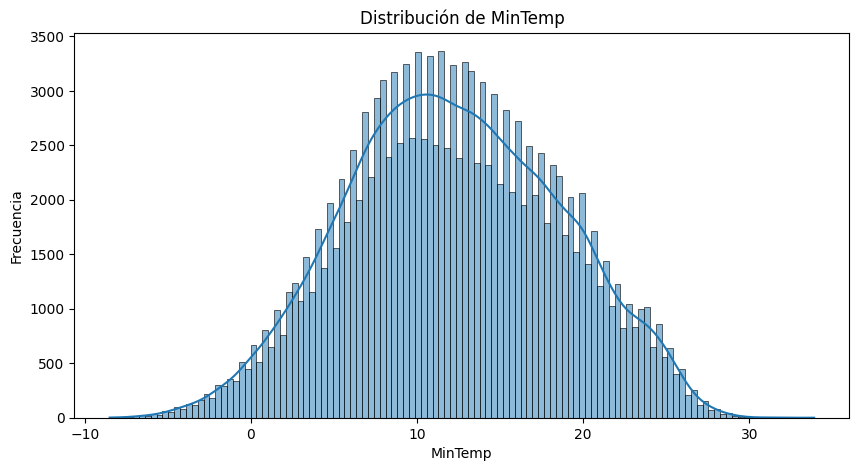

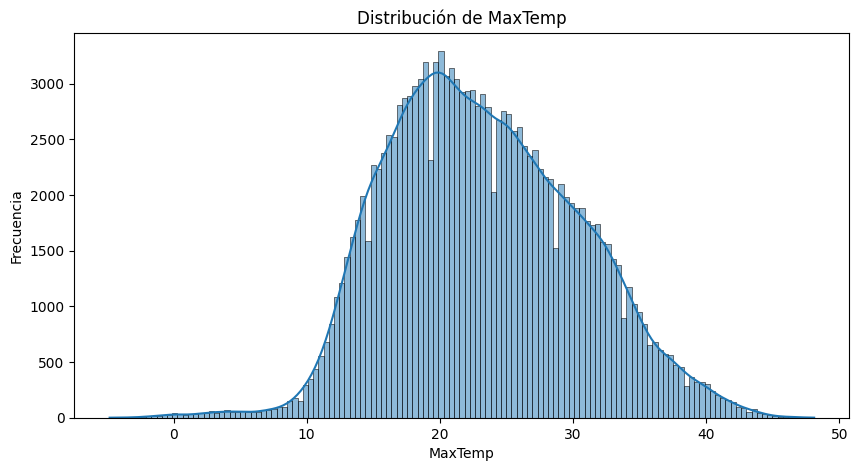

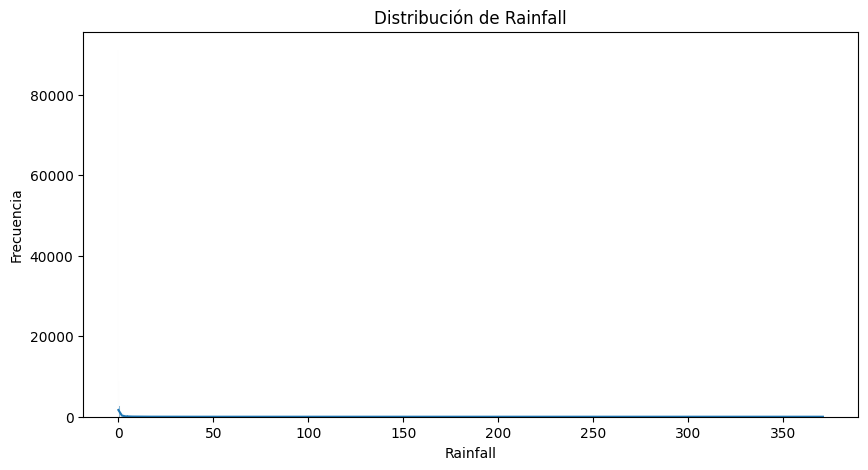

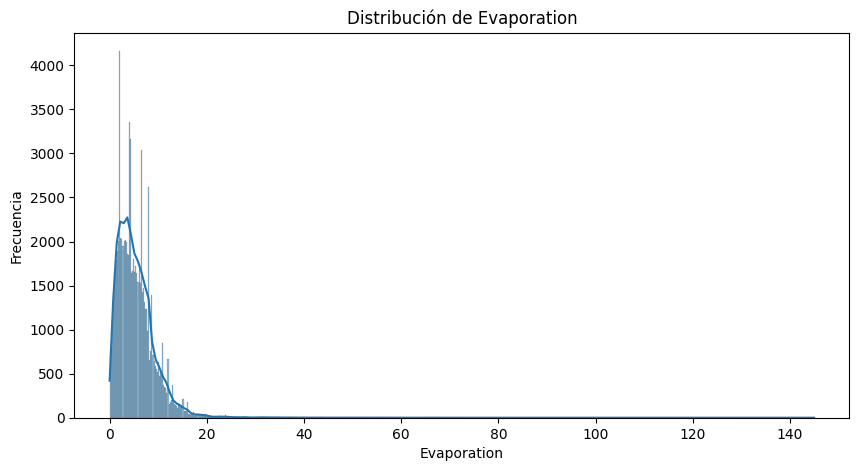

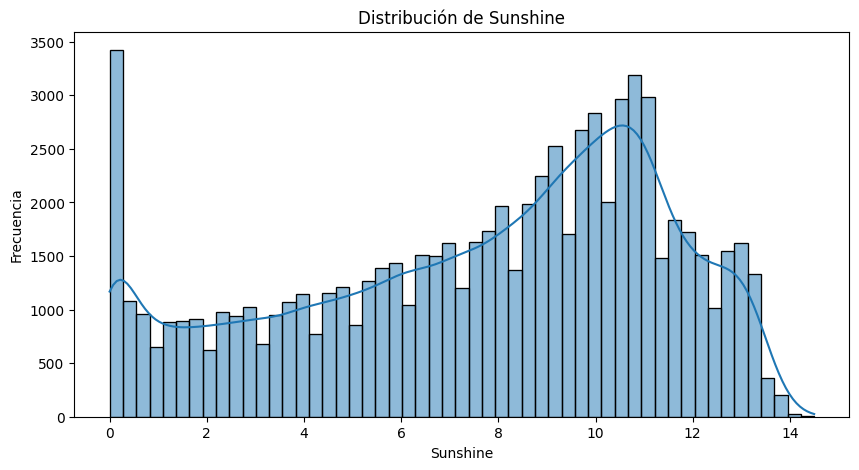

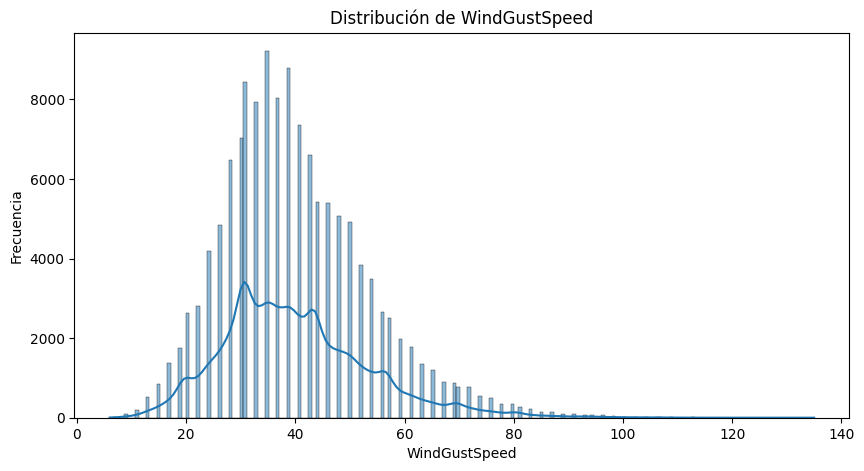

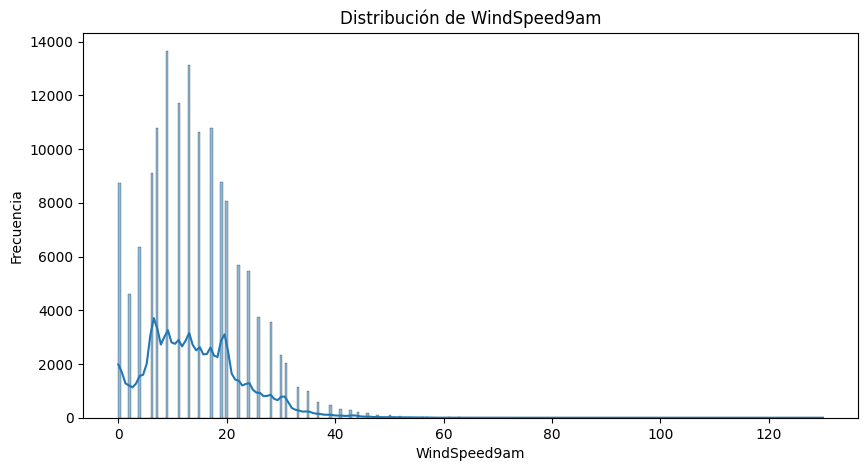

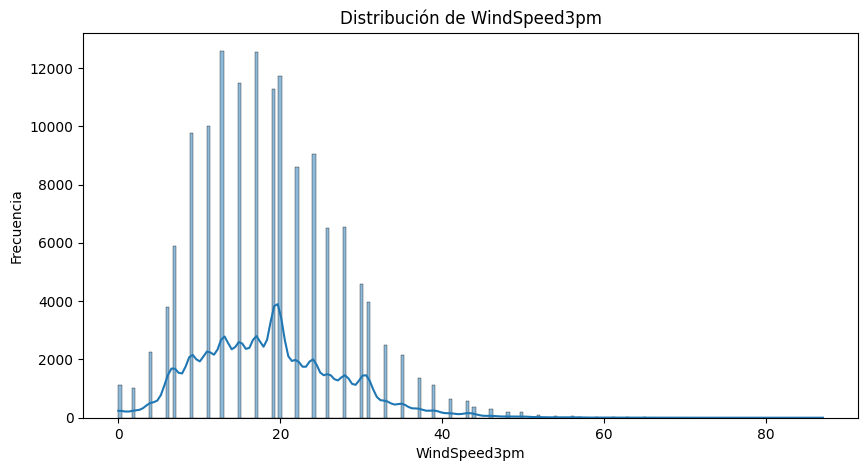

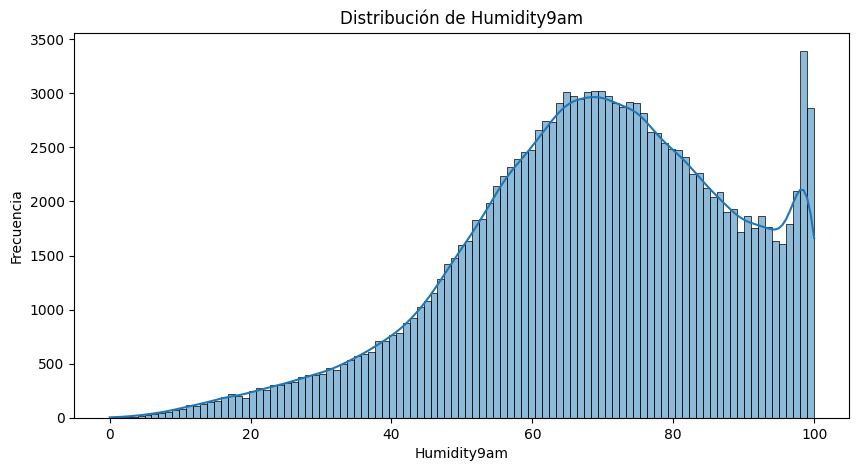

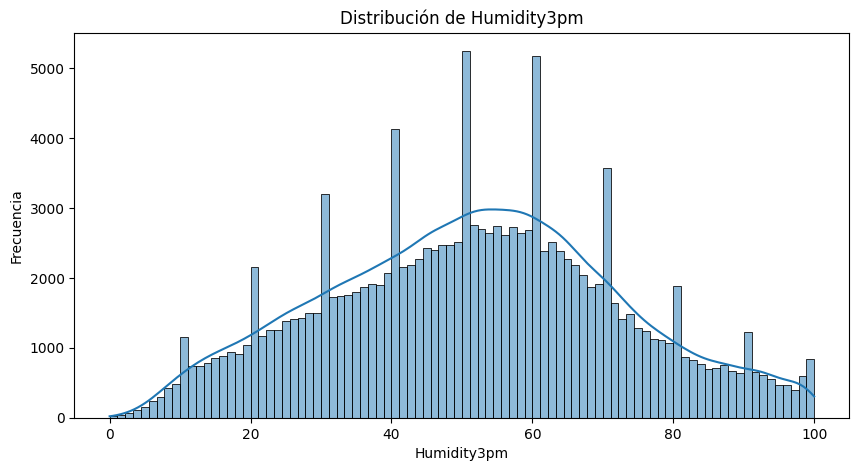

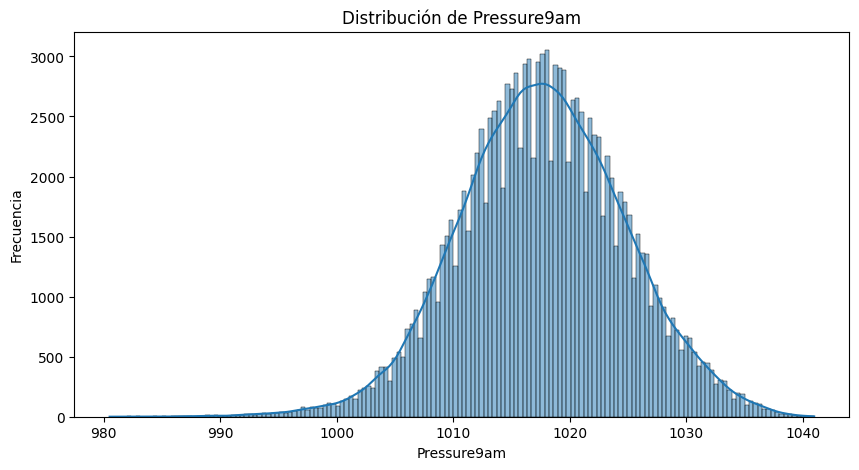

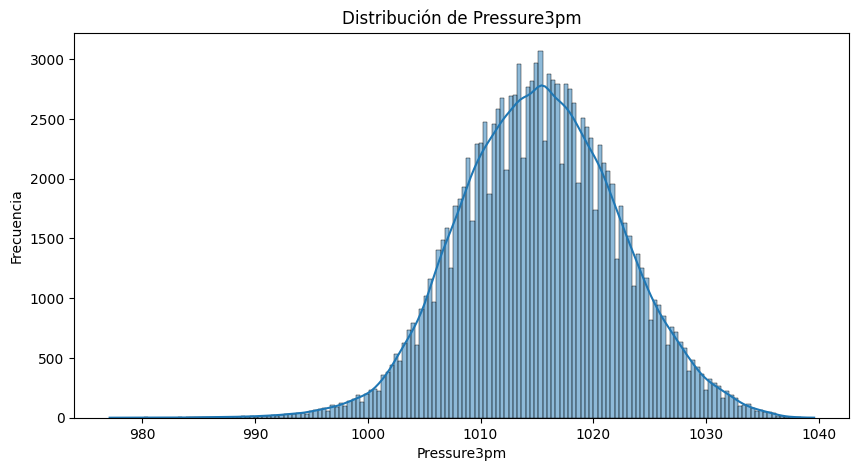

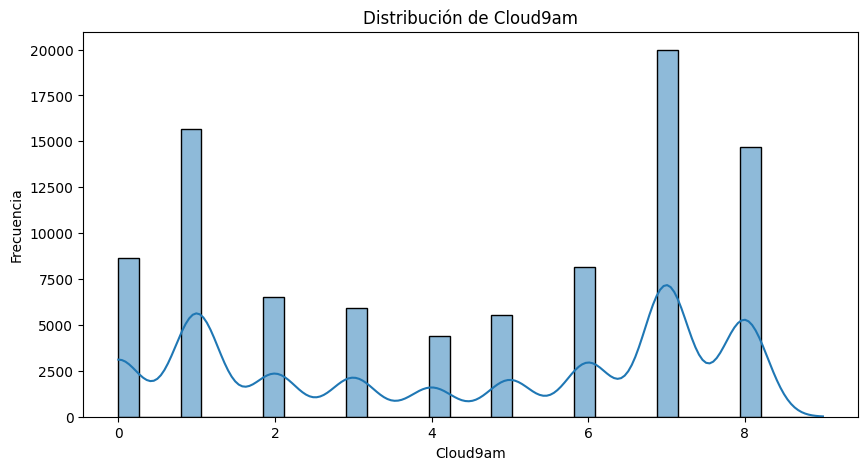

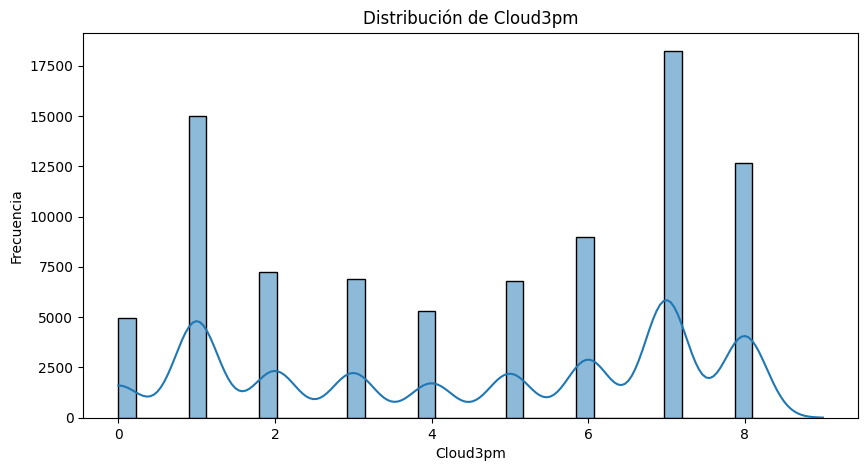

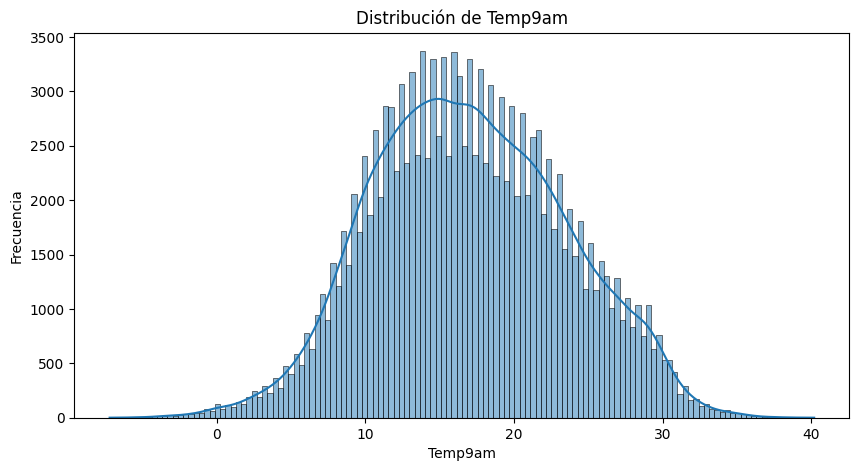

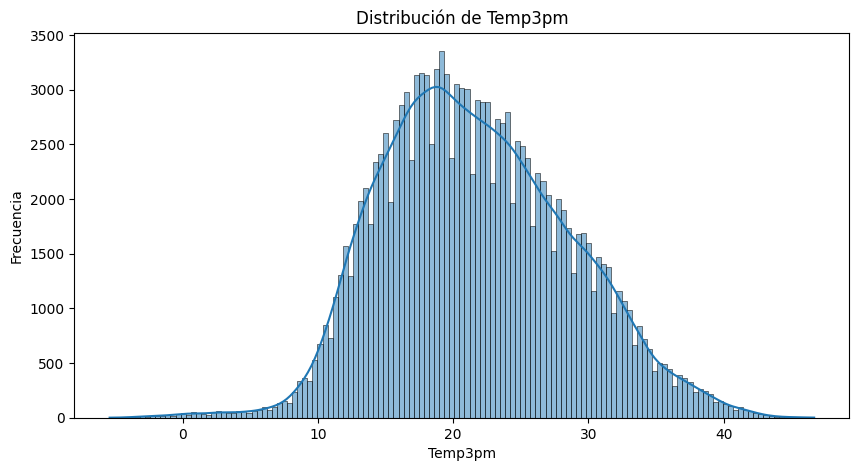

In [63]:
for column in weather_data.columns:
    # Comprobar si los datos son numéricos
    if weather_data[column].dtype in ['int64', 'float64']:
        # Filtrar los datos para excluir los valores nulos
        data = weather_data[weather_data[column].notnull()][column]
        
        # Crear un histograma con seaborn
        plt.figure(figsize=(10, 5))  # Ajustar el tamaño del gráfico
        sns.histplot(data, kde=True)
        
        # Añadir título y etiquetas
        plt.title(f'Distribución de {column}')
        plt.xlabel(column)
        plt.ylabel('Frecuencia')
        
        # Mostrar el gráfico
        plt.show()

# Crear boxplot con seaborn

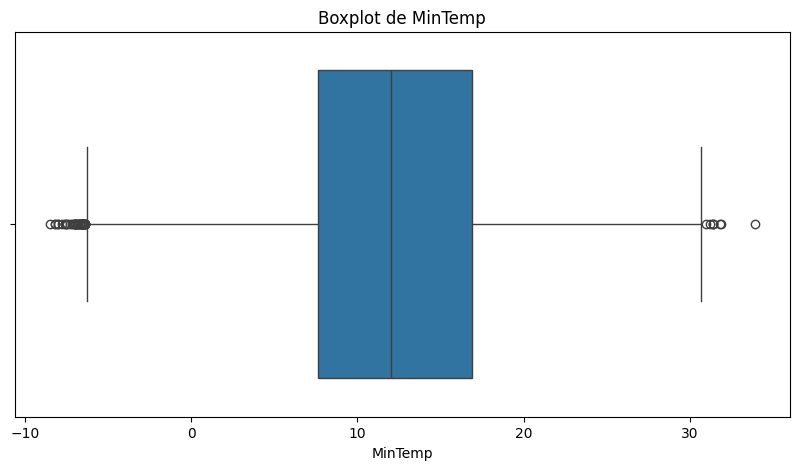

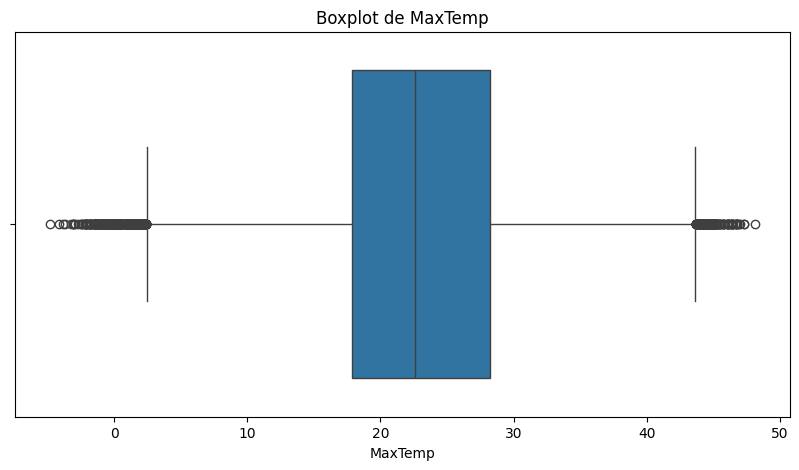

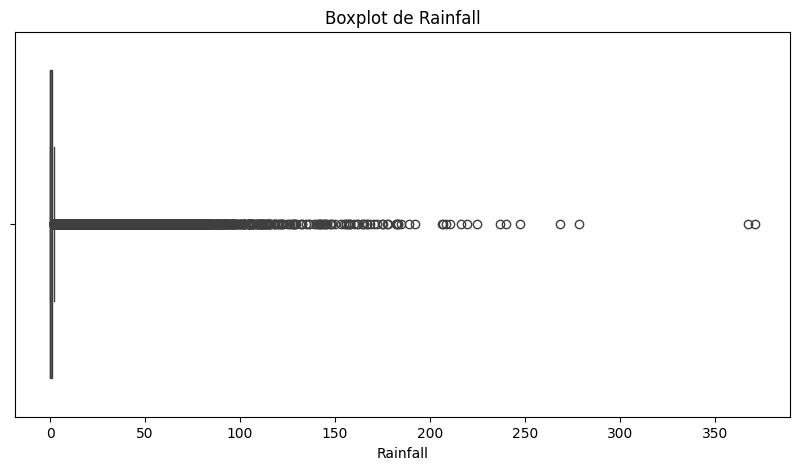

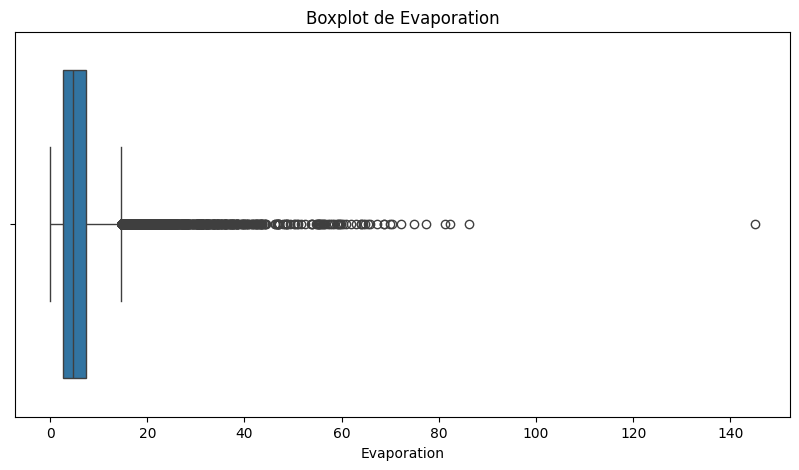

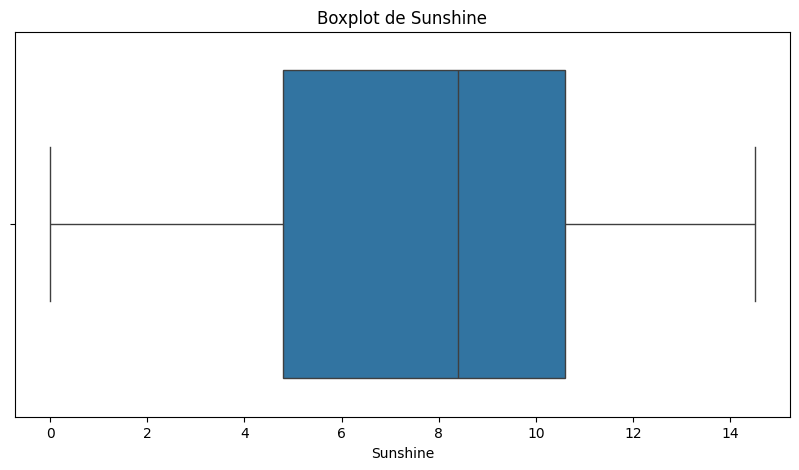

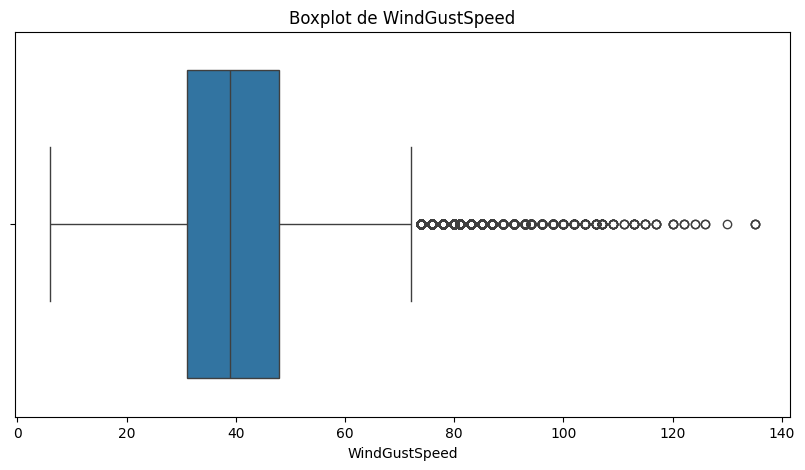

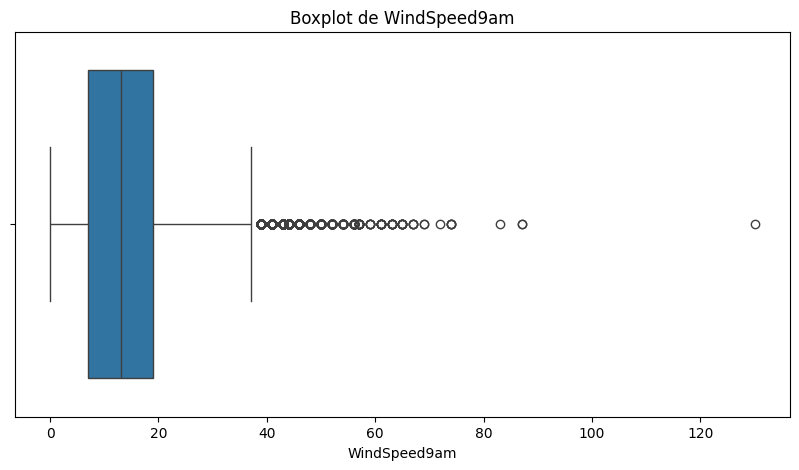

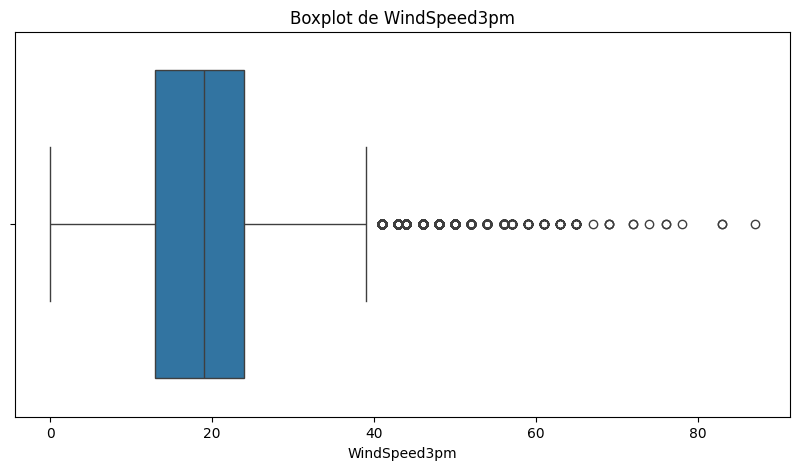

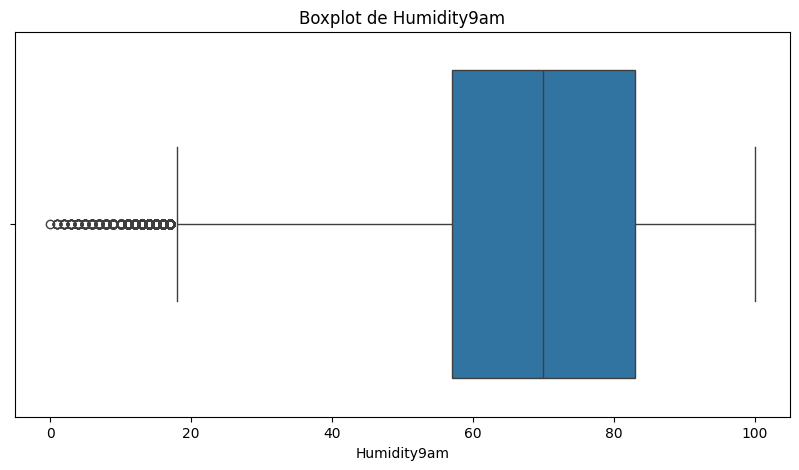

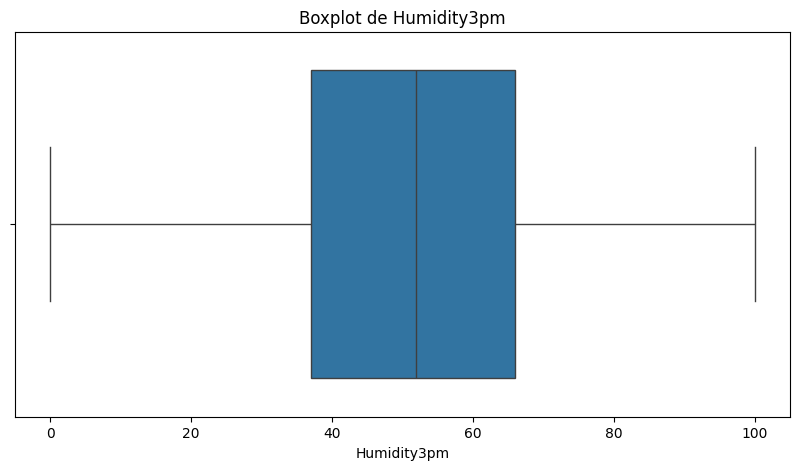

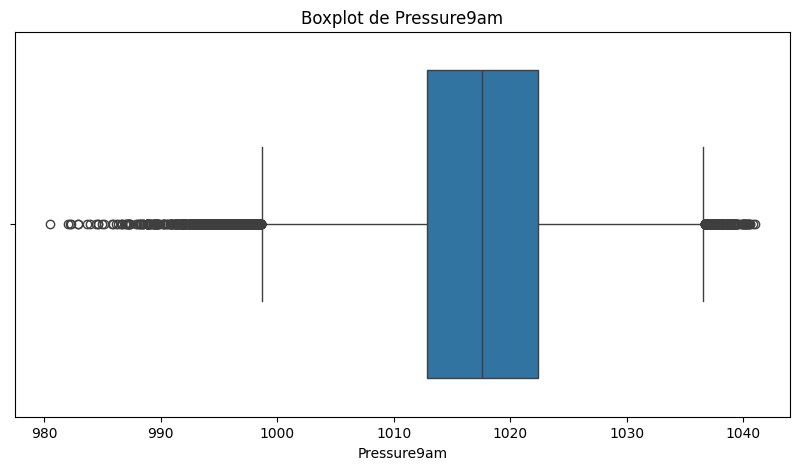

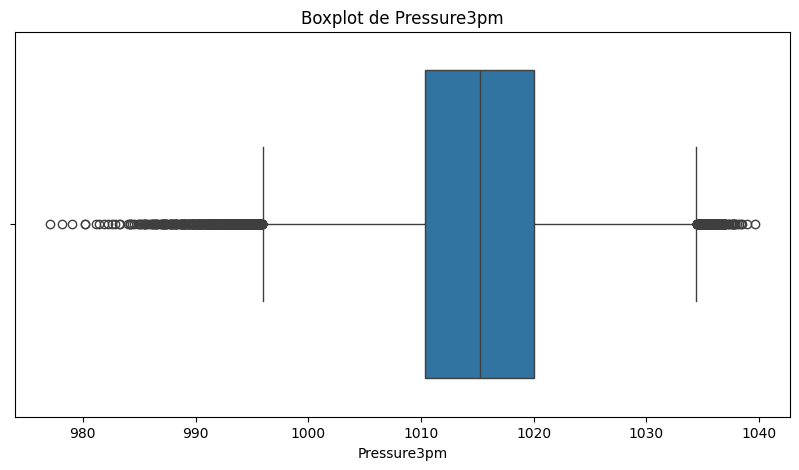

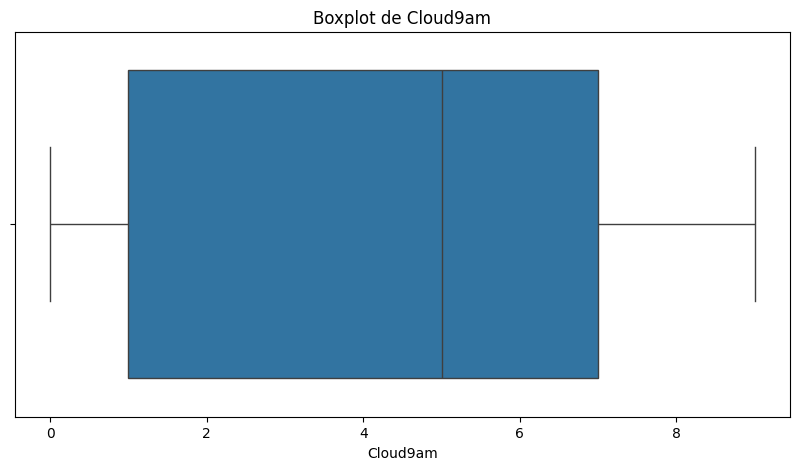

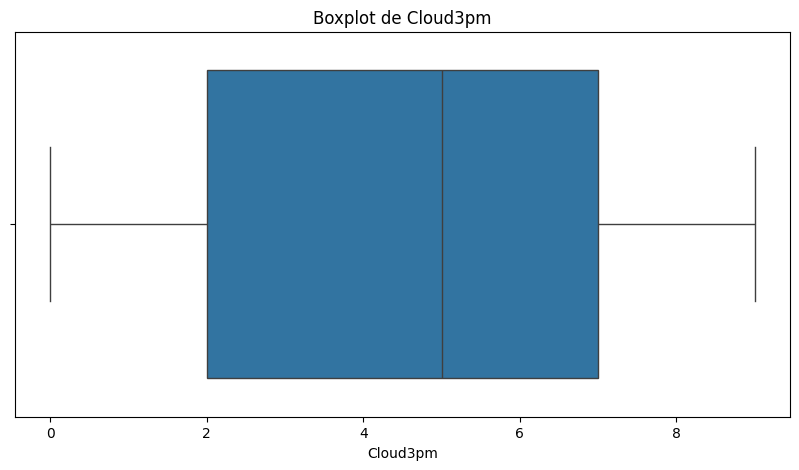

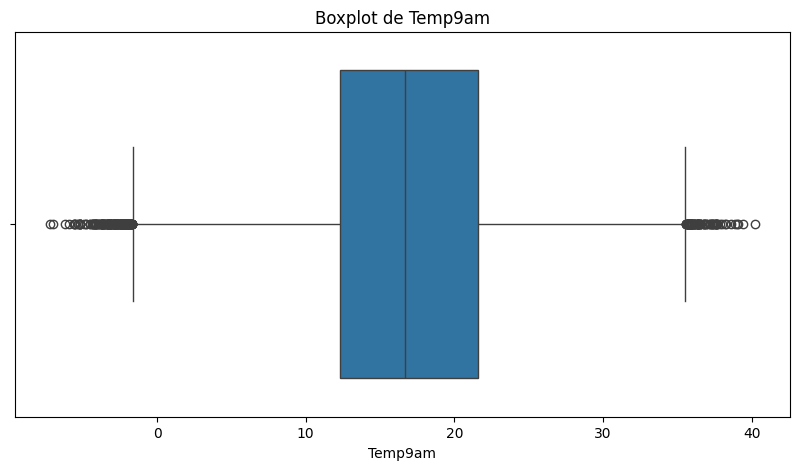

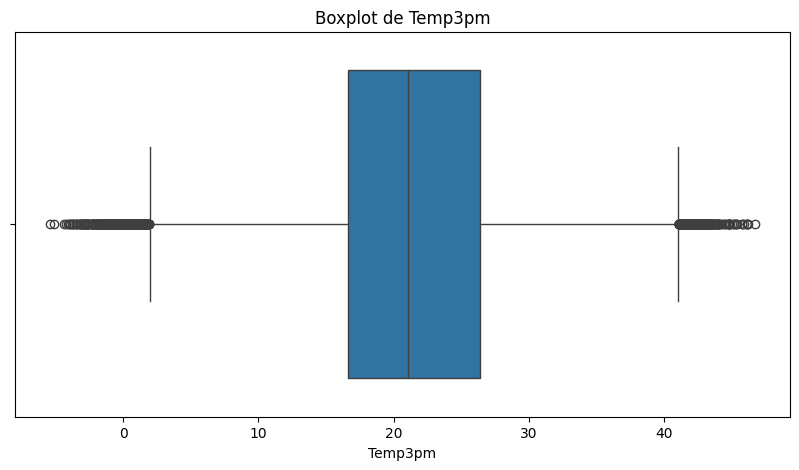

In [64]:
for column in weather_data.columns:
    if weather_data[column].dtype in ['int64', 'float64']:
        data = weather_data[weather_data[column].notnull()][column]
        
        plt.figure(figsize=(10, 5))  
        sns.boxplot(x=data)        
        plt.title(f'Boxplot de {column}')
        plt.xlabel(column)        
        plt.show()

In [11]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       92289 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

In [464]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

# def train_model_and_fill_data():
#     # Seleccionar características y variable objetivo
#     features = ['MaxTemp', 'MinTemp', 'Rainfall']
#     target = 'Sunshine'

#     # Filtrar filas con valores reales de Sunshine
#     real_values = weather_data.dropna(subset=[target])

#     # Filtrar filas con valores generados para Sunshine
#     imputed_values_df = weather_data[weather_data[target].isna()]

#     # Separar características y variable objetivo
#     X = real_values[features]
#     y = real_values[target]
#     X_missing = imputed_values_df[features]

#     # Dividir los datos en conjuntos de entrenamiento y prueba
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Imputar valores faltantes en las características
#     imputer = SimpleImputer(strategy='mean')
#     X_train_imputed = imputer.fit_transform(X_train)
#     X_test_imputed = imputer.transform(X_test)
#     X_missing_imputed = imputer.transform(X_missing)

#     # Instanciar y entrenar un modelo de regresión lineal
#     regression_model = LinearRegression()
#     regression_model.fit(X_train_imputed, y_train)

#     # Predecir valores faltantes de Sunshine
#     imputed_values = regression_model.predict(X_missing_imputed)

#     # Predecir valores en el conjunto de prueba
#     y_pred = regression_model.predict(X_test_imputed)

#     # Calcular el error cuadrático medio y el coeficiente de determinación R^2
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     print(f"Mean squared error: {mse}")
#     print(f"R^2: {r2}")

#     # Graficar los valores reales vs los valores predichos
#     plt.scatter(y_test, y_pred)
#     plt.xlabel('True Values')
#     plt.ylabel('Predictions')
#     plt.grid(True)
#     plt.show()

#     # Actualizar valores faltantes en el conjunto de datos original
#     weather_data.loc[imputed_values_df.index, target] = imputed_values

In [68]:
# # check if there are any missing values in sunshine column
# if weather_data['Sunshine'].isnull().sum() > 0:
#     train_model_and_fill_data()

# Analisis Grafico de los Datos vs RainTomorrow

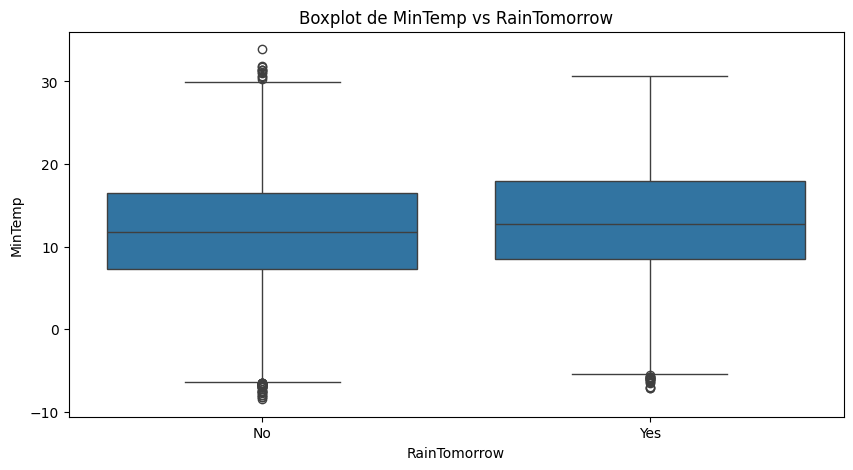

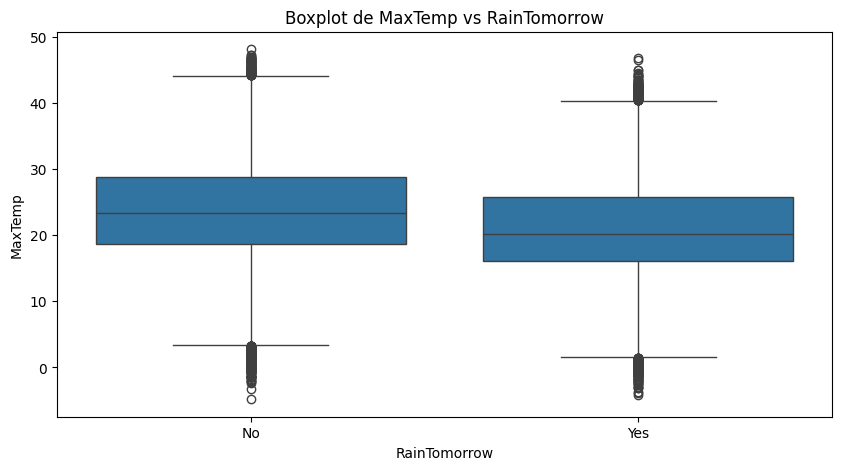

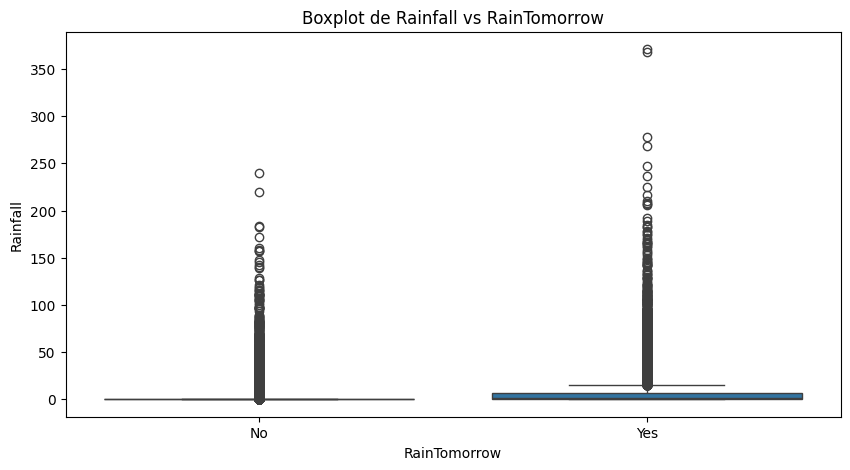

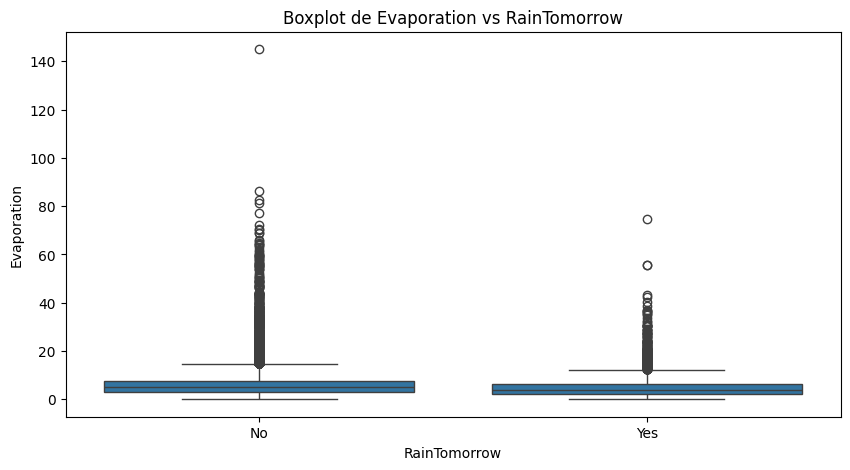

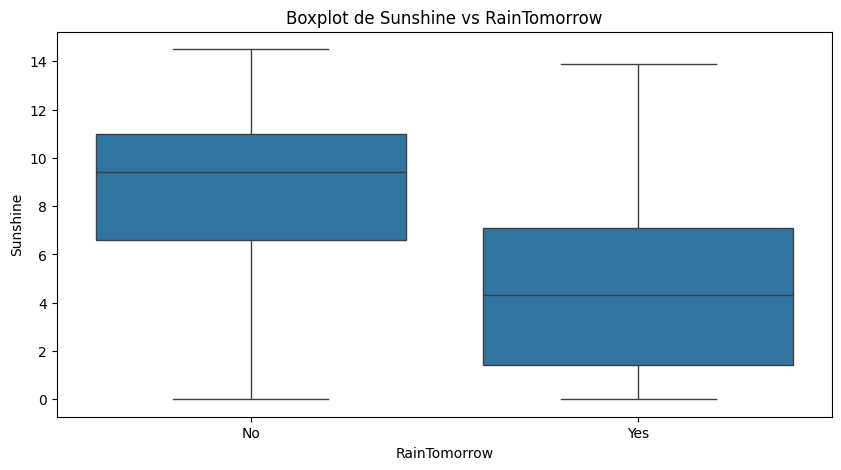

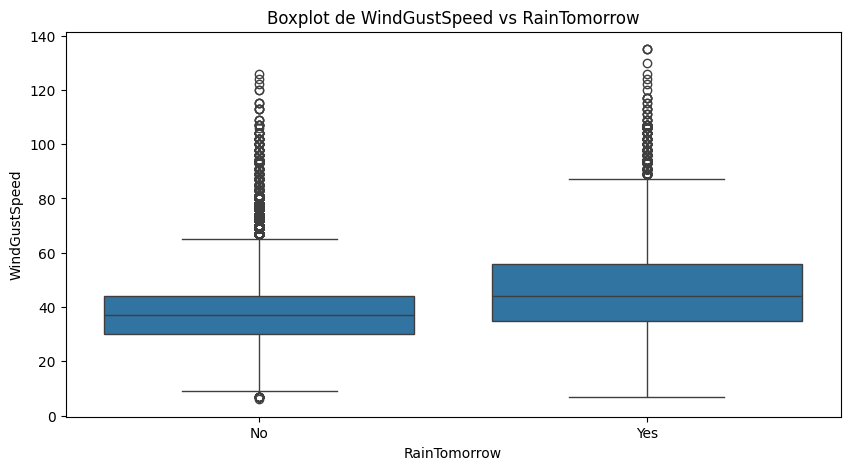

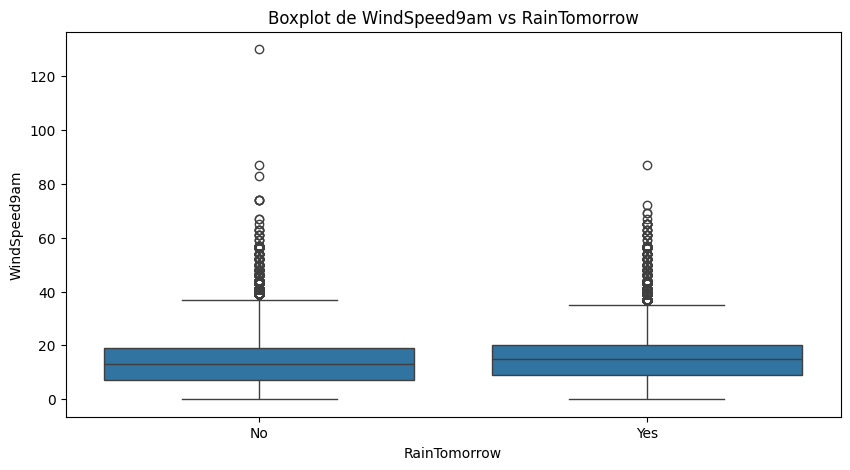

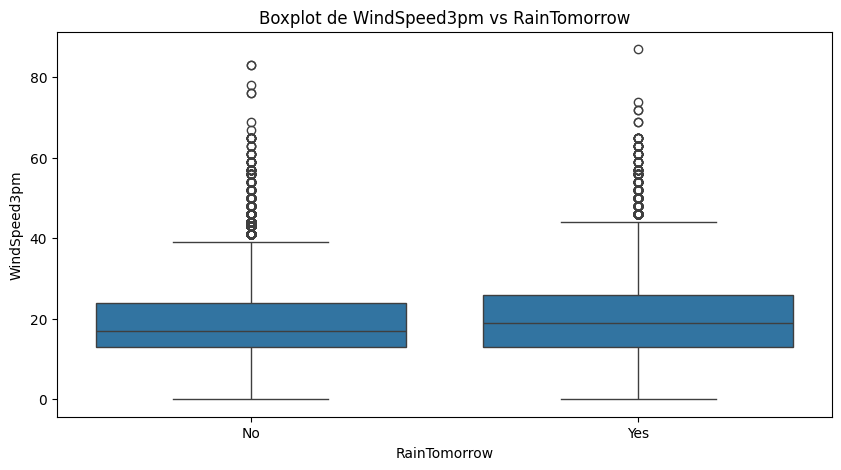

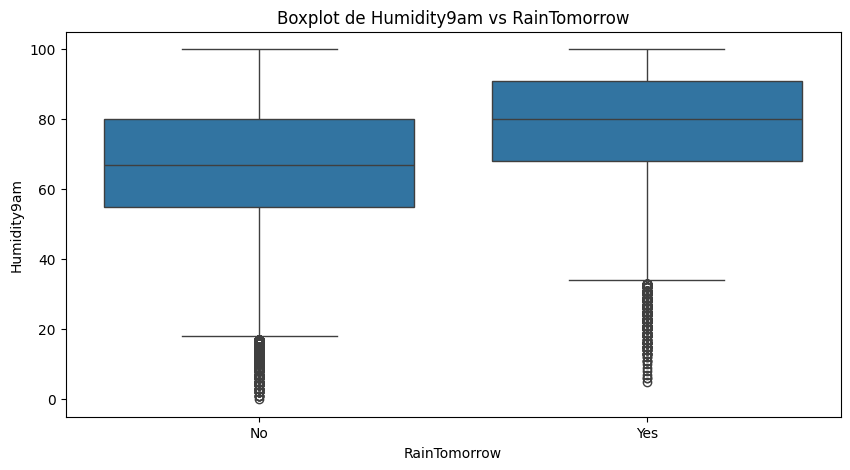

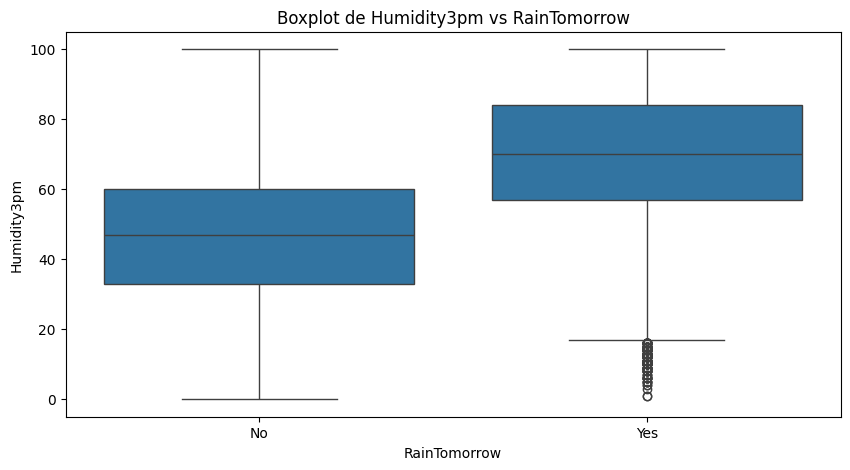

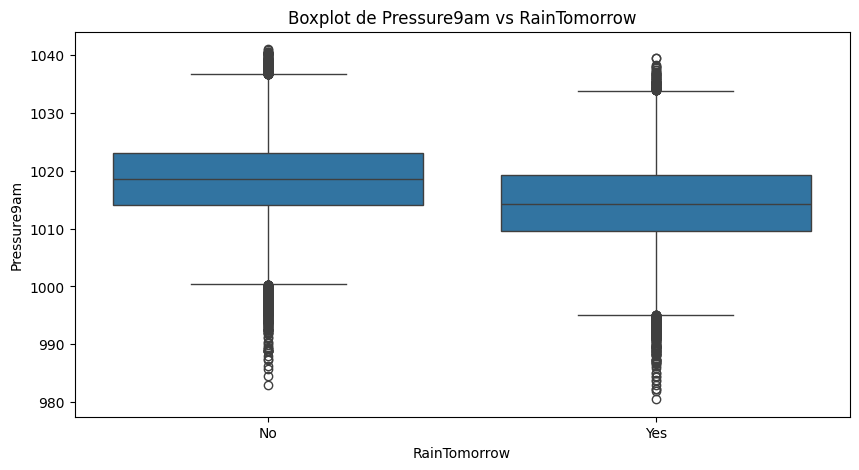

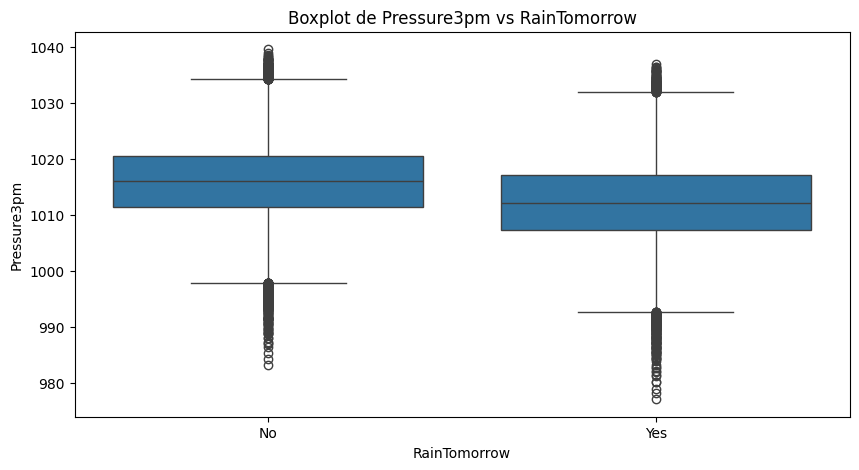

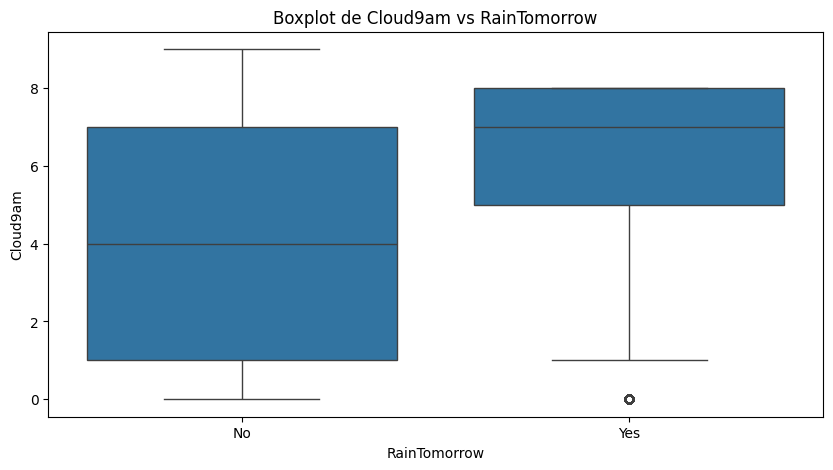

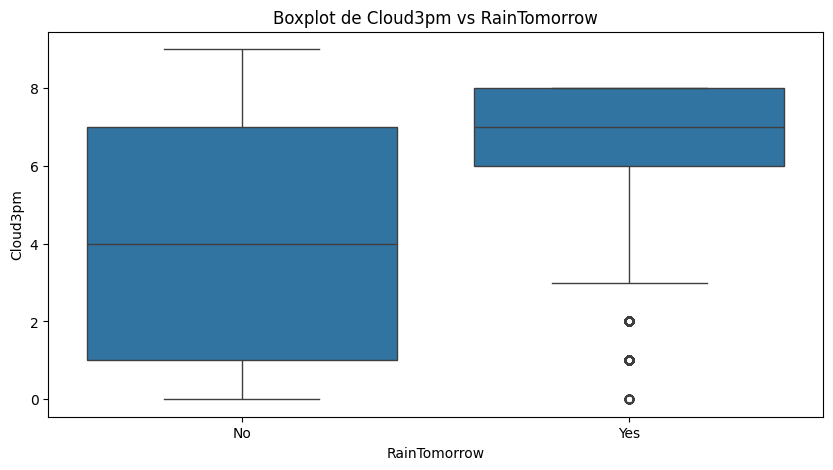

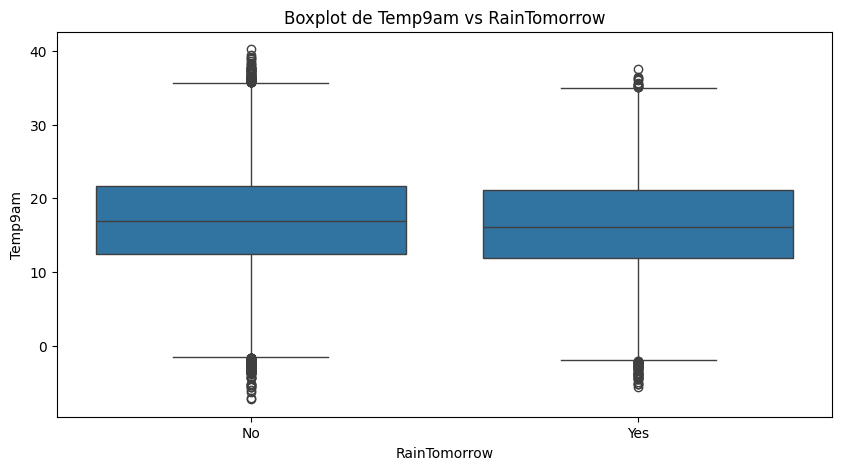

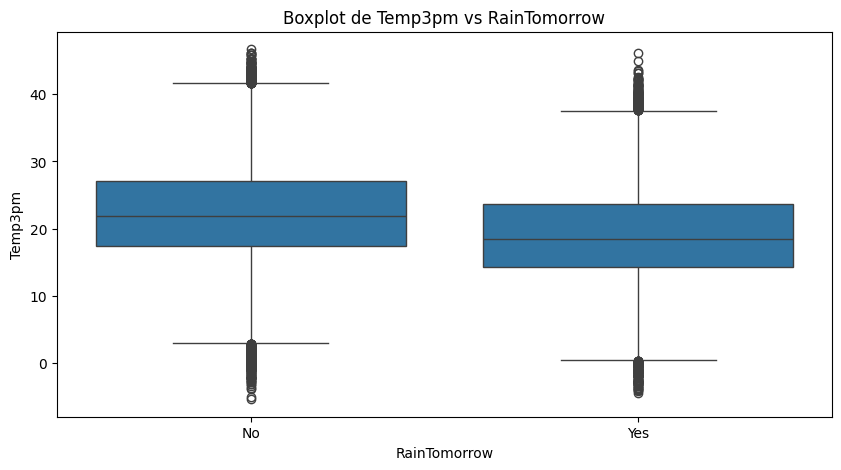

In [67]:
for column in weather_data.columns:
    if weather_data[column].dtype in ['int64', 'float64']:
        plt.figure(figsize=(10, 5))  
        sns.boxplot(x=weather_data['RainTomorrow'], y=weather_data[column])
        
        plt.title(f'Boxplot de {column} vs RainTomorrow')
        plt.ylabel(column)
        plt.xlabel('RainTomorrow')
        plt.show()